# Machine Learning : Model Fit

# Load the packages

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib

# gradient boosting for regression in scikit-learn
from numpy import mean
from numpy import std
#from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

from sklearn.datasets import make_classification
#from sklearn.experimental import enable_hist_gradient_boosting

In [2]:
from lightgbm import LGBMClassifier

/Users/eunbinkim/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Read the train data set 

In [3]:
import pickle
 
X, y = pickle.load( open( "cluster-mldata.plk", "rb" ) )

In [4]:
X.shape

(2134, 2)

In [5]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [6]:
y.shape

(2134,)

# Model: LightGBMClassifier
# Simple Fit using the whole train sample

In [7]:
# Fit the model on the whole dataset
model = LGBMClassifier()
model.fit(X, y)
y_pred = model.predict(X)

In [8]:
X[:3]

array([[ 1.45014512, -0.91556924],
       [ 1.50100449, -1.83122128],
       [ 0.34456645, -3.06349221]])

In [9]:
print(y_pred)

[0 0 0 ... 0 0 1]


In [10]:
# Make a single prediction
# row = [[0.90156951, 0.01291567]]
row = X
yhat = model.predict(row)

In [11]:
yhat

array([0, 0, 0, ..., 0, 0, 1])

In [12]:
yhat.shape

(2134,)

In [13]:
print(y[0])
print('Prediction: %f' % yhat[0])

0
Prediction: 0.000000


# Check the accuracy and confusion matrix

In [14]:
from sklearn.metrics import accuracy_score

accuracy_score(y, y_pred)

0.8978444236176195

Text(24.0, 0.5, 'Label')

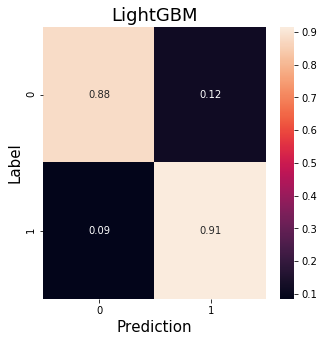

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn 

conf_mx = confusion_matrix(y, y_pred)
conf_mx

cm = confusion_matrix(y, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))

hm = sn.heatmap(cmn, annot=True, fmt='.2f')#, x_label='label')
hm.axes.set_title("LightGBM",fontsize=18)
hm.set_xlabel('Prediction',fontsize=15)
hm.set_ylabel('Label',fontsize=15)

# Trying Various Hyper-parameters : Grid Search

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
# Set params
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'n_estimators' : 100,
          'num_leaves': 31,
          'learning_rate': 0.001,
          'objective': 'binary',
          'nthread': 1,       
          'max_bin': 512,
          'subsample_for_bin': 5000,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'metric' : 'binary_error'
         }

In [18]:
# Model setting
mdl = LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 1,
          silent = True,
          max_depth = params['max_depth'],
          n_estimators = params['n_estimators'],
          learning_rate = params['learning_rate'],
          num_leaves = params['num_leaves'])
                     
# To view the default model params:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [19]:
# Create grid parameters to search
gridParams = {
    'learning_rate': [0.0005,0.001,0.005],
    'num_leaves': [15,30,50,100],
    'n_estimators': [100,200,300],
}   

In [20]:
# Create the grid
allmodels = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=5,
                    n_jobs=1)

In [21]:
%%time
# Run the grid

allmodels.fit(X, y)

CPU times: user 18.1 s, sys: 48.3 ms, total: 18.1 s
Wall time: 18.1 s


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.001, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=1, num_leaves=31,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=1,
             param_grid={'learning_rate': [0.0005, 0.0

In [22]:
print(allmodels.best_params_)

{'learning_rate': 0.005, 'n_estimators': 300, 'num_leaves': 15}


In [23]:
print(allmodels.best_score_)

0.787684577409814


In [24]:
fmodel = allmodels.best_estimator_

In [25]:
fmodel.predict_proba(X[0:3])

array([[0.75020197, 0.24979803],
       [0.85558284, 0.14441716],
       [0.88388653, 0.11611347]])

In [26]:
fmodel.predict(X[0:3])

array([0, 0, 0])

# Prediction using the best model

In [27]:
y_pred = fmodel.predict(X)

In [28]:
y_pred[:6]

array([0, 0, 0, 0, 0, 0])

In [29]:
y[:6]

array([0, 0, 0, 0, 0, 0])

# Check the accuracy and Confusion matrix

In [30]:
from sklearn.metrics import accuracy_score

accuracy_score(y, y_pred)

0.8252108716026242

In [31]:
# make cm
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y, y_pred)
conf_mx

array([[802, 210],
       [163, 959]])

In [32]:
pd.crosstab(y, y_pred)

col_0,0,1
row_0,,
0,802,210
1,163,959


Text(33.0, 0.5, 'Label')

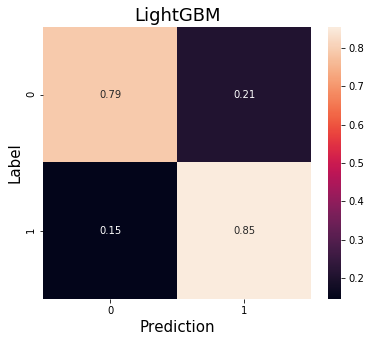

In [33]:
# plot cm
import seaborn as sn

cm = confusion_matrix(y, y_pred)
# normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(6,5))
hm = sn.heatmap(cmn, annot=True, fmt='.2f')#, x_label='label')
hm.axes.set_title("LightGBM",fontsize=18)
hm.set_xlabel('Prediction',fontsize=15)
hm.set_ylabel('Label',fontsize=15)